# Natural Language Processing for Campaign Speeches

### Previous Notebook [Mini Time Series Modeling](Mini_Time_posing.ipynb)
### Next Notebook [Conclusions in Outline Notebook](Outline_Project.ipynb)

This section analysis the election speechs of the presidential nominees from 2004 through 2016. The first section processes the speeches into a usable foramt and removes special characters and the candidates name from the speeches.
- [Preprocessing](#section1)

The second section predicts the party of the candidate that gaves the speech based of which words and the frequency in which they they appear. As well as the sentimentand and polarity analysis of each of the speeches.
- [Modeling - Predicting Party](#section2)
- [Modeling - Predicting Election](#section3)

The third and forth sections show the most freequent words by party, and then by election.
- [Most Frequent Words by Party](#section3)
- [Most Frequent Words by Election](#section4)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import re
from tqdm import *

%matplotlib inline

import spacy
from textblob import TextBlob, Word

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics as m


from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical

Using TensorFlow backend.
/Users/Penelope/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
# read in needed files
df_kerry = pd.read_csv('./csv_files/speech_kerry')
df_bush = pd.read_csv('./csv_files/speech_bush')
df_obama = pd.read_csv('./csv_files/speech_obama')
df_mccain = pd.read_csv('./csv_files/speech_mccain')
df_obama_2 = pd.read_csv('./csv_files/speech_obama_2')
df_romney = pd.read_csv('./csv_files/speech_romney')
df_clinton = pd.read_csv('./csv_files/speech_clinton')
df_trump = pd.read_csv('./csv_files/speech_trump')

<a id='section1'></a>
# Preprocessing

In [4]:
# Add features to indicate election year and party of candidate
df_kerry['party'] = 1
df_kerry['year'] = 2004
df_bush['party'] = 0
df_bush['year'] = 2004
df_obama['party'] = 1
df_obama['year'] = 2008
df_mccain['party'] = 0
df_mccain['year'] = 2008
df_obama_2['party'] = 1
df_obama_2['year'] = 2012
df_romney['party'] = 0
df_romney['year'] = 2012
df_clinton['party'] = 1
df_clinton['year'] = 2016
df_trump['party'] = 0
df_trump['year'] = 2016

In [5]:
# combine the speeches of all the candidates

df = pd.concat([df_kerry, df_bush, df_obama, df_mccain, df_obama_2, df_romney, 
                df_clinton, df_trump], axis=0, ignore_index=True)

In [6]:
df.reindex()
df.shape

(1004, 4)

Remove all special characters and names of candidates so predicting party is base on only content.

In [7]:
df['speech'] = df['speech'].apply(lambda x: x.lower().replace("\\'", "'"))
df['speech'] = df['speech'].apply(lambda x: x.replace("""'""", """"""))
df['speech'] = df['speech'].apply(lambda x: x.replace('''"''', ''''''))
df['speech'] = df['speech'].apply(lambda x: x.replace(".", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace(",", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("-", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace(";", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace(":", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("going", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("kerry", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("john", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("bush", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("george", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("obama", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("barack", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("mccain", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("romeny", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("mitt", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("clinton", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("hillary", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("trump", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("donald", ""))

Create columns that show the subjectivity and polarity score of each speech

In [8]:
%%timeit

subjectivity = []
polarity = []
for i in range(0, len(df.speech)):
    sub = TextBlob(df.speech[i]).sentiment.subjectivity
    subjectivity.append(sub)
    
    pol = TextBlob(df.speech[i]).sentiment.polarity
    polarity.append(pol)

df['subjectivity'] = subjectivity
df['polarity'] = polarity

1 loop, best of 3: 44.5 s per loop


Gets the stem of each word so that words with the same root registed in the model as the same word

In [9]:
%%timeit

sp = []

for speech in df.speech:
    stem_list = []
    speech_new = []
    speech = speech.split()
    for word in speech:
        w = Word(word)
        stem = w.stem()
        stem_list.append(stem)
    speech_new = ' '.join(stem_list)
    sp.append(speech_new)

# define a new column that holds the speeches with words in stem form. So that the speech columns remains intact.
df['stems'] = sp

1 loop, best of 3: 1min 33s per loop


<a id='section2'></a>
# Modeling - Predicting Party

- [Logistic Regression](#subsection1)
- [Random Forest Classifier](#subsection2)
- [Neural Network](#subsection3)

<a id='subsection1'></a>
## Logistic Regression

In [10]:
# define the predictive features and the predicted columns

X = df[['stems', 'subjectivity', 'polarity']]
y = df.party

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

# initialize vectoizer
tfidf = TfidfVectorizer(stop_words='english')

# fit and transform training data
tfidf.fit(X_train.stems)
X_train_tf = tfidf.transform(X_train.stems)

# turn into data frame and concat
X_train_tf = pd.DataFrame(X_train_tf.todense())
train_sub_pol = X_train[['subjectivity', 'polarity']].reset_index().drop(['index'], axis=1)
X_train_tf = pd.concat([X_train_tf, train_sub_pol], axis=1)


# test data
X_test_tf = tfidf.transform(X_test.stems)
X_test_tf = pd.DataFrame(X_test_tf.todense())
test_sub_pol = X_test[['subjectivity', 'polarity']].reset_index().drop(['index'], axis=1)
X_test_tf = pd.concat([X_test_tf, test_sub_pol], axis=1)


# initialize and fit model
logreg = LogisticRegression()
logreg.fit(X_train_tf, y_train)
train_predictions = logreg.predict(X_train_tf)

print('Train Accuracy Score', logreg.score(X_train_tf, y_train))
print('Cross Validated Accuracy Train Score', cross_val_score(logreg, X_train_tf, y_train, cv=5).mean())


test_predictions = logreg.predict(X_test_tf)
print('Test Accuracy Score', logreg.score(X_test_tf, y_test))
print('Cross Validated Accuracy Test Score', cross_val_score(logreg, X_test_tf, y_test, cv=5).mean())
print(m.confusion_matrix(y_test, test_predictions))
print(m.classification_report(y_test, test_predictions))

Train Accuracy Score 0.97150997151
Cross Validated Accuracy Train Score 0.914527162978
Test Accuracy Score 0.966887417219
Cross Validated Accuracy Test Score 0.877540983607
[[105   7]
 [  3 187]]
             precision    recall  f1-score   support

          0       0.97      0.94      0.95       112
          1       0.96      0.98      0.97       190

avg / total       0.97      0.97      0.97       302



The Cross Validated Accuracy Score on the test data is 0.87

This model is is 87% accurate when predicting the party on new data. 
The confusion martix shows that the model predicted that 3 speeches as Democratic but were actually Republican. 
It incorrectly predicted 7 speeches were Republican, that were actually Democratic.

<a id='subsection2'></a>
## Random Forest Classifier

This model uses Random Forest Classifier, an ensemble method with a base of Decision Tree. This model doesn't preform as well as the Logistic Regression so it is not included in the final report. 

In [11]:
# define the predictive features and the predicted columns

X = df[['stems', 'subjectivity', 'polarity']]
y = df.party

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X_train.stems)
X_train_tf = tfidf.transform(X_train.stems)


X_train_tf = pd.DataFrame(X_train_tf.todense())


train_sub_pol = X_train[['subjectivity', 'polarity']].reset_index().drop(['index'], axis=1)
X_train = pd.concat([X_train_tf, train_sub_pol], axis=1)


rfc = RandomForestClassifier(max_depth=36, n_estimators=22)

rfc.fit(X_train, y_train)
train_predictions = rfc.predict(X_train)

print('Train Accuracy Score', rfc.score(X_train, y_train))
print('Cross Validated Accuracy Train Score', cross_val_score(rfc, X_train, y_train, cv=5).mean())

# vectorize and concat test data
X_test_tf = tfidf.transform(X_test.stems)
X_test_tf = pd.DataFrame(X_test_tf.todense())

test_sub_pol = X_test[['subjectivity', 'polarity']].reset_index().drop(['index'], axis=1)
X_test = pd.concat([X_test_tf, test_sub_pol], axis=1)


test_predictions = rfc.predict(X_test)
print('Accuracy Score', rfc.score(X_test, y_test))
print('Cross Validated Accuracy Test Score', cross_val_score(rfc, X_test, y_test, cv=5).mean())
print(m.confusion_matrix(y_test, test_predictions))
print(m.classification_report(y_test, test_predictions))

Train Accuracy Score 1.0
Cross Validated Accuracy Train Score 0.871730382294
Accuracy Score 0.903973509934
Cross Validated Accuracy Test Score 0.824316939891
[[ 89  23]
 [  6 184]]
             precision    recall  f1-score   support

          0       0.94      0.79      0.86       112
          1       0.89      0.97      0.93       190

avg / total       0.91      0.90      0.90       302



The Random Forest model actually produces a better accuracy score on the training data. But the cross validated accuracy on the test data is much better in the Logistic Regression. Indicating that this model is better at predicting the party of new data. 

The point of predicting the party of the speeches is to show that there are fundamental differences in the words choosen by the nominees each party has.

### GridSearch on Random Forest Classifier

The following code was a GridSearch on used with the Random Forest Classifier to optimize the hyper paramers. This increased the Cross Validated Score on the Test data, but not enough to challenge the results from Logistic Regression.

tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X_train.speech)
X_train_tf = tfidf.transform(X_train.speech)


X_train_tf = pd.DataFrame(X_train_tf.todense())


train_sub_pol = X_train[['subjectivity', 'polarity']].reset_index().drop(['index'], axis=1)
X_train_tf = pd.concat([X_train_tf, train_sub_pol], axis=1)

rfc = RandomForestClassifier()


params = {
    'n_estimators':range(5, 26),
    'max_depth':range(5, 40),  
}

grid = GridSearchCV(rfc, params, verbose=2, n_jobs=-1)

grid.fit(X_train_tf, y_train)
grid.best_estimator_


### Random Forest Classifier - Most Indicative Words

This section results a dataframe of the most words that were the most indicative of party

In [12]:
feature_names = tfidf.get_feature_names() 
feature_names.append('subjectivity') 
feature_names.append('polarity')
importance = list(rfc.feature_importances_)
results = pd.DataFrame()
results['feature_names'] = feature_names
results['feature_importances'] = importance

results = results[results['feature_importances'] > .005]

results

,feature_names,feature_importances
2550,auto,0.005557
2964,becaus,0.007296
5221,colleg,0.012612
7818,drill,0.006767
8087,educ,0.008257
9426,final,0.006670
11169,hard,0.011425
13026,islam,0.007509
13513,just,0.005381
20044,research,0.007790


<a id='subsection3'></a>
## Neural Network - Keras with TensorFlow backend

In [13]:
# define the predictive features and the predicted columns

X = df[['stems', 'subjectivity', 'polarity']]
y = df.party

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

# initialize vectorizer 
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X_train.stems)

# fit and transform training data with vectoizer
X_train_tf = tfidf.transform(X_train.stems)
X_train_tf = pd.DataFrame(X_train_tf.todense())

# transform test data with vectorizer
X_test_tf = tfidf.transform(X_test.stems)
X_test_tf = pd.DataFrame(X_test_tf.todense())

# concat the vecotried matrixes 
train_sub_pol = X_train[['subjectivity', 'polarity']].reset_index().drop(['index'], axis=1)
test_sub_pol = X_test[['subjectivity', 'polarity']].reset_index().drop(['index'], axis=1)

X_train = pd.concat([X_train_tf, train_sub_pol], axis=1)
X_test = pd.concat([X_test_tf, test_sub_pol], axis=1)

# standardize data
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [14]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [15]:
model = Sequential()
model.add(Dense(1000, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(.5))
model.add(Dense(500, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(.5))
model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Train on 702 samples, validate on 302 samples
Epoch 1/10
702/702 [==============================] - 14s 20ms/step - loss: 1.0505 - acc: 0.7023 - val_loss: 0.1756 - val_acc: 0.9338
Epoch 2/10
702/702 [==============================] - 13s 19ms/step - loss: 0.3271 - acc: 0.9245 - val_loss: 0.1307 - val_acc: 0.9470
Epoch 3/10
702/702 [==============================] - 14s 21ms/step - loss: 0.3025 - acc: 0.9615 - val_loss: 0.1232 - val_acc: 0.9669
Epoch 4/10
702/702 [==============================] - 14s 20ms/step - loss: 0.2624 - acc: 0.9701 - val_loss: 0.2523 - val_acc: 0.9570
Epoch 5/10
702/702 [==============================] - 14s 20ms/step - loss: 0.2672 - acc: 0.9815 - val_loss: 0.2965 - val_acc: 0.9702
Epoch 6/10
702/702 [==============================] - 13s 18ms/step - loss: 0.3118 - acc: 0.9715 - val_loss: 0.4398 - val_acc: 0.9404
Epoch 7/10
702/702 [==============================] - 13s 18ms/step - loss: 0.3049 - acc: 0.9715 - val_loss: 0.3621 - val_acc: 0.9603
Epoch 8/10
702/7

In [16]:
pred_train = model.predict_classes(X_train)

print(m.confusion_matrix(y_train, pred_train))
print(m.classification_report(y_train, pred_train))

[[276   0]
 [ 16 410]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.97       276
          1       1.00      0.96      0.98       426

avg / total       0.98      0.98      0.98       702



In [17]:
pred_test = model.predict_classes(X_test)

print(m.confusion_matrix(y_test, pred_test))
print(m.classification_report(y_test, pred_test))

[[111   1]
 [ 12 178]]
             precision    recall  f1-score   support

          0       0.90      0.99      0.94       112
          1       0.99      0.94      0.96       190

avg / total       0.96      0.96      0.96       302



<a id='section3'></a>
# Modeling Two - Predicting Election Year

## Neural Network - Keras

Finding the baseline

In [18]:
y = df.year.apply(lambda x: 1 if x == 2004 else (2 if x == 2008 else(3 if x == 2012 else 4)))

print(len(y))
print(y.value_counts())
baseline = 402/1004

1004
2    402
4    270
3    205
1    127
Name: year, dtype: int64


In [19]:
# define the predictive features and the predicted columns
X = df[['stems', 'subjectivity', 'polarity']]
y = df.year.apply(lambda x: 1 if x == 2004 else (2 if x == 2008 else(3 if x == 2012 else 4)))
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

# initialize vectorizer 
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X_train.stems)

# fit and transform training data with vectoizer
X_train_tf = tfidf.transform(X_train.stems)
X_train_tf = pd.DataFrame(X_train_tf.todense())

# transform test data with vectorizer
X_test_tf = tfidf.transform(X_test.stems)
X_test_tf = pd.DataFrame(X_test_tf.todense())

# concat the vecotried matrixes 
train_sub_pol = X_train[['subjectivity', 'polarity']].reset_index().drop(['index'], axis=1)
test_sub_pol = X_test[['subjectivity', 'polarity']].reset_index().drop(['index'], axis=1)

X_train = pd.concat([X_train_tf, train_sub_pol], axis=1)
X_test = pd.concat([X_test_tf, test_sub_pol], axis=1)

# standardize the data 
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

model = Sequential()
model.add(Dense(1000, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(.5))
model.add(Dense(500, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(.5))
model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=20)

pred_test = model.predict(X_test)

Train on 702 samples, validate on 302 samples
Epoch 1/15
702/702 [==============================] - 26s 38ms/step - loss: 0.7625 - acc: 0.7994 - val_loss: 0.3830 - val_acc: 0.8715
Epoch 2/15
702/702 [==============================] - 21s 29ms/step - loss: 0.4800 - acc: 0.9134 - val_loss: 0.1409 - val_acc: 0.9523
Epoch 3/15
702/702 [==============================] - 21s 30ms/step - loss: 0.3000 - acc: 0.9527 - val_loss: 0.1689 - val_acc: 0.9550
Epoch 4/15
702/702 [==============================] - 20s 28ms/step - loss: 0.2362 - acc: 0.9687 - val_loss: 0.1275 - val_acc: 0.9722
Epoch 5/15
702/702 [==============================] - 19s 27ms/step - loss: 0.2074 - acc: 0.9761 - val_loss: 0.1840 - val_acc: 0.9702
Epoch 6/15
702/702 [==============================] - 20s 28ms/step - loss: 0.1452 - acc: 0.9823 - val_loss: 0.1157 - val_acc: 0.9775
Epoch 7/15
702/702 [==============================] - 19s 27ms/step - loss: 0.1448 - acc: 0.9872 - val_loss: 0.1625 - val_acc: 0.9715
Epoch 8/15
702/7

In [20]:
pred_test = (pred_test == pred_test.max(axis=1, keepdims=True)).astype(float)

pred_test = pred_test.argmax(1)
y_test = y_test.argmax(1)

print('Confusion Matrix \n', pd.crosstab(y_test, pred_test, rownames=['Actual'], colnames=['Predicted'], 
                                         margins=True))

Confusion Matrix 
 Predicted   1    2   3   4  All
Actual                         
1          36    3   0   2   41
2           0  130   0   1  131
3           0    3  51   1   55
4           0    7   0  68   75
All        36  143  51  72  302


Accuracy Score is 97% compared to a baseline of 40%

<a id='section4'></a>
# Most Frequent Words in Speeches by Party

In [21]:
df['speech'] = df['speech'].apply(lambda x: x.replace("applause", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("laughter", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("laughr", ""))

df['speech'] = df['speech'].apply(lambda x: x.replace("america", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("american", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("think", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("this", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("thats", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("make", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("know", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("want", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("im ", " "))
df['speech'] = df['speech'].apply(lambda x: x.replace("weve", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("got", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("just", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("like", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("need", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("said", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("cheers", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("te ", " "))
df['speech'] = df['speech'].apply(lambda x: x.replace("ns ", " "))
df['speech'] = df['speech'].apply(lambda x: x.replace("dont", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("senator", ""))
df['speech'] = df['speech'].apply(lambda x: x.replace("president", ""))

df['speech'] = df['speech'].apply(lambda x: x.replace("unemployed", "unemployment")
                                  .replace("unemployments", "unemployment").replace("jobs", "unemployment"))
df['speech'] = df['speech'].apply(lambda x: x.replace("school", "education").replace("teachers", "education")
                                  .replace("teachers", "education").replace("student", "education")
                                  .replace("students", "education").replace("literacy", "education")
                                  .replace("literate", "education").replace("college", "education"))

In [28]:
df['speech'] = df['speech'].apply(lambda x: x.replace("wealth", "income").replace("class", "income")
                                  .replace("billionaire", "income"))
df['speech'] = df['speech'].apply(lambda x: x.replace("afordable", "equality").replace("comprehensive", "equality")
                                  .replace("comprehensive", "equality"))
df['speech'] = df['speech'].apply(lambda x: x.replace("immigrant", "immigration").replace("migrant", "immigration")
                                  .replace("migration", "immigration").replace("mexico", "immigration")
                                  .replace("wall", "immigration"))
df['speech'] = df['speech'].apply(lambda x: x.replace("troops", "war").replace("iraq", "war")
                                  .replace("iran", "war").replace("fight", "war").replace("security", "war")
                                  .replace("military", "war")
                                  .replace("enemies", "war"))
df['speech'] = df['speech'].apply(lambda x: x.replace("oil", "energy"))
df['speech'] = df['speech'].apply(lambda x: x.replace("children", "families"))
df['speech'] = df['speech'].apply(lambda x: x.replace("taxation", "tax")).replace("job", "unemployment")\
                                .replace("worker", "unemployment").replace("workers", "unemployment")\
                                .replace("work", "unemployment")

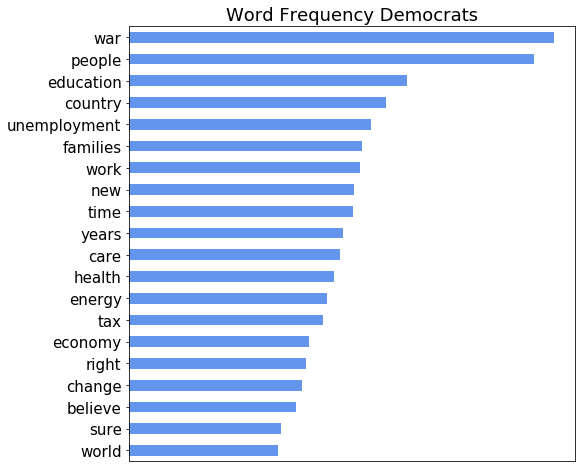

In [30]:
X = df[df.party == 1]
# print('Democratic Average Subjectivity', X.subjectivity.mean())
# print('Democratic Average Polarity', X.polarity.mean())
X = X.speech

tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X)

count = pd.DataFrame(tfidf.transform(X).todense(),columns=tfidf.get_feature_names())
count = count/100

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
plt.tick_params(axis='x', which='both', bottom='off', labelbottom='off')
plt.yticks(fontsize=15)

count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='cornflowerblue')
plt.title('Word Frequency Democrats', fontsize=18);

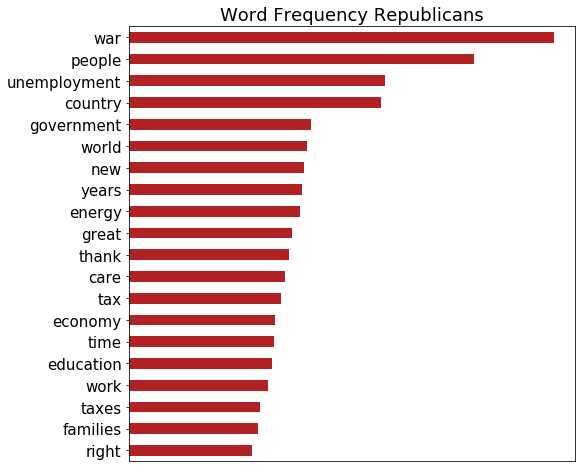

In [31]:
X = df[df.party == 0]
# print('Republican Average Subjectivity', X.subjectivity.mean())
# print('Republican Average Polarity', X.polarity.mean())
X = X.speech

tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X)

count = pd.DataFrame(tfidf.transform(X).todense(),columns=tfidf.get_feature_names())
count = count/100
  
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
plt.tick_params(axis='x', which='both', bottom='off', labelbottom='off')    
plt.yticks(fontsize=15)
    
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='firebrick')
plt.title('Word Frequency Republicans', fontsize=18);

<a id='section5'></a>
# Most Frequent Words by Election

- [2004](#subsection5)
- [2008](#subsection6)
- [2012](#subsection7)
- [2016](#subsection8)

<a id='subsection5'></a>
## 2004

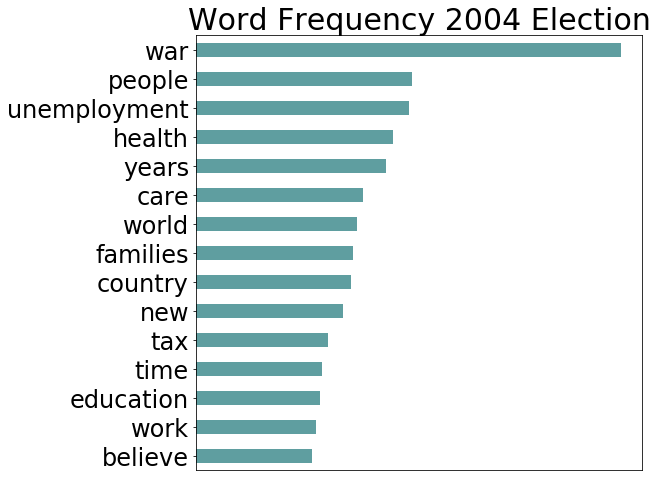

In [60]:
X = df[df.year == 2004]
# print('2004 Average Democratic Subjectivity', X[X.party == 1].subjectivity.mean())
# print('2004 Average Republican Subjectivity', X[X.party == 0].subjectivity.mean())
# print('2004 Average Democratic Polarity', X[X.party == 1].polarity.mean())
# print('2004 Average Republican Polarity', X[X.party == 0].polarity.mean())
X = X.speech

tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X)

count = pd.DataFrame(tfidf.transform(X).todense(),columns=tfidf.get_feature_names())
# count = count/100

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
plt.tick_params(axis='x', which='both', bottom='off', labelbottom='off')
plt.yticks(fontsize=24)

count.sum().sort_values(ascending=True)[-15:].plot(kind='barh', color='cadetblue')
plt.title('Word Frequency 2004 Election', fontsize=30);

<a id='subsection6'></a>
## 2008

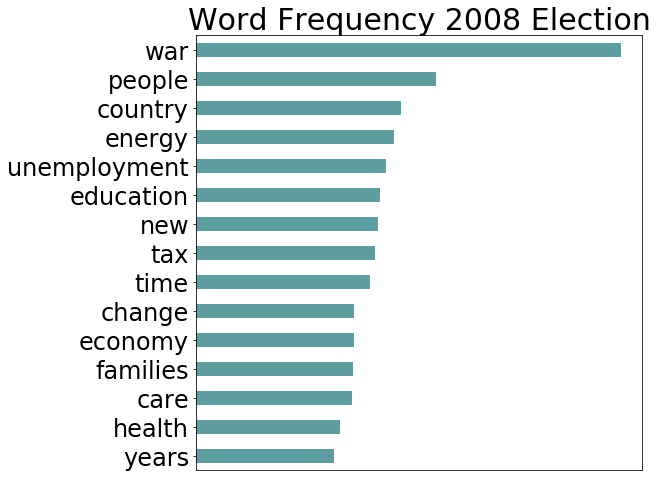

In [59]:
X = df[df.year == 2008]
# print('2008 Average Democratic Subjectivity', X[X.party == 1].subjectivity.mean())
# print('2008 Average Republican Subjectivity', X[X.party == 0].subjectivity.mean())
# print('2008 Average Democratic Polarity', X[X.party == 1].polarity.mean())
# print('2008 Average Republican Polarity', X[X.party == 0].polarity.mean())
X = X.speech

tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X)

count = pd.DataFrame(tfidf.transform(X).todense(),columns=tfidf.get_feature_names())
# count = count/100

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
plt.tick_params(axis='x', which='both', bottom='off', labelbottom='off')
plt.yticks(fontsize=24)

count.sum().sort_values(ascending=True)[-15:].plot(kind='barh', color='cadetblue')
plt.title('Word Frequency 2008 Election', fontsize=30);

<a id='subsection7'></a>
## 2012

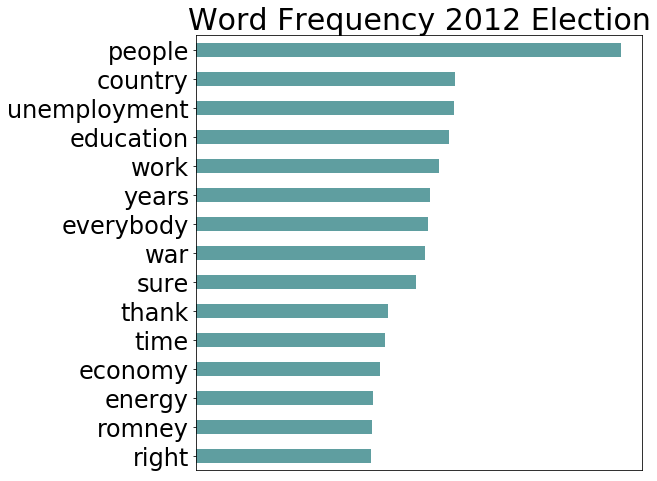

In [58]:
X = df[df.year == 2012]
# print('2012 Average Democratic Subjectivity', X[X.party == 1].subjectivity.mean())
# print('2012 Average Republican Subjectivity', X[X.party == 0].subjectivity.mean())
# print('2012 Average Democratic Polarity', X[X.party == 1].polarity.mean())
# print('2012 Average Republican Polarity', X[X.party == 0].polarity.mean())
X = X.speech

tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X)

count = pd.DataFrame(tfidf.transform(X).todense(),columns=tfidf.get_feature_names())
# count = count/100

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
plt.tick_params(axis='x', which='both', bottom='off', labelbottom='off')
plt.yticks(fontsize=24)

count.sum().sort_values(ascending=True)[-15:].plot(kind='barh', color='cadetblue')
plt.title('Word Frequency 2012 Election', fontsize=30);

<a id='subsection8'></a>
## 2016

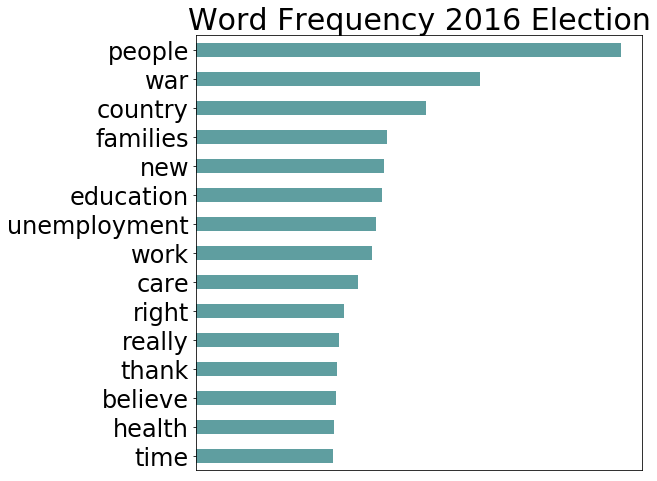

In [57]:
X = df[df.year == 2016]
# print('2016 Average Democratic Subjectivity', X[X.party == 1].subjectivity.mean())
# print('2016 Average Republican Subjectivity', X[X.party == 0].subjectivity.mean())
# print('2016 Average Democratic Polarity', X[X.party == 1].polarity.mean())
# print('2016 Average Republican Polarity', X[X.party == 0].polarity.mean())
X = X.speech

tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X)

count = pd.DataFrame(tfidf.transform(X).todense(), columns=tfidf.get_feature_names())
# count = count/100

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
plt.tick_params(axis='x', which='both', bottom='off', labelbottom='off')
plt.yticks(fontsize=24)

count.sum().sort_values(ascending=True)[-15:].plot(kind='barh', color='cadetblue')
plt.title('Word Frequency 2016 Election', fontsize=30);

### Next Notebook [Conclusions in Outline Notebook](Outline_Project.ipynb)